In [13]:
# Modules used for handling and visualization of data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

# Modules used for computer vision
import cv2
from PIL import Image, ImageEnhance

# Modules used for handling files
import os
from xml.dom import minidom
import xml.etree.ElementTree as ET

# Modules used for randomization
import random as r

# Constants
TRAIN_DIR = "../data/atrw_detection_train/trainval/"
TEST_DIR =  "../data/input/atrw-detection-dataset/atrw_detection_test/test"
ANNOT_DIR = "../data/atrw_anno_detection_train(1)/Annotations"

In [14]:
class EDA: 
    
    # Initialization of the variables for EDA.
    def __init__(self):
        self.train_image_paths = []
        self.ROWS = 4
        self.COLS = 1
        self.img = None
    
    # Function to create bounding boxes with xmin, xmax, ymin, ymax.
    def __create_bnd_box(self, bnd_box_dims : list):
        # Traveral through all the dimensions for
        # each tiger.
        for bnd_box_idx in bnd_box_dims:
            
            # Retrieval of the information.
            bnd_box_dim = bnd_box_dims[bnd_box_idx]
            
            # Computation of the length and width of the
            # bounding box.
            dx = bnd_box_dim["xmax"] - bnd_box_dim["xmin"]
            dy = bnd_box_dim["ymax"] - bnd_box_dim["ymin"]
            
            # Annotation of the box onto the image.
            cv2.rectangle(self.img, (bnd_box_dim["xmin"], bnd_box_dim["ymin"]), 
                          (bnd_box_dim["xmin"] + dx, bnd_box_dim["ymin"] + dy), 
                          color=(0,255,255), 
                          thickness=5)
    
    # Extraction of the bounding box dimensions by parsing XML.
    def __get_bndbox_dim(self, id: str):
        bnd_box_dims = dict()
        
        # Parsing the XML annotations file. 
        xml_path = os.path.join(ANNOT_DIR, id+".xml")
        file = ET.parse(xml_path)
        
        # Traversal through the XML Tree.
        root=file.getroot()
        all_tigers = root[6:]
        for tgr_idx in range(0, len(all_tigers)):
            bnd_box_dims[tgr_idx] = dict()
            tgr_dim = all_tigers[tgr_idx][4][0:]
            for dim_idx in range(0, len(tgr_dim)):
                dim_val = tgr_dim[dim_idx].text.strip()
                bnd_box_dims[tgr_idx][tgr_dim[dim_idx].tag] = int(dim_val)
        
        # Creation of bounding boxes.
        self.__create_bnd_box(bnd_box_dims)
    
    # Display of sample images with bounding boxes.
    def display_sample_images(self):
        # Initialization of the subplot.
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS,
                                figsize=(10,10))
        
        # Randomly sampling four images.
        self.train_image_paths = sorted(os.listdir(TRAIN_DIR))
        self.randomly_chosen = r.choices(self.train_image_paths, 
                                         k=4)
        
        # Displaying images with the bounding boxes.
        for img_path in self.randomly_chosen:
            full_img_path = os.path.join(TRAIN_DIR, img_path)
            self.img = mpimg.imread(full_img_path)
            img_id = img_path.split(".")[0]
            self.__get_bndbox_dim(img_id)
            axs[c//self.COLS].imshow(self.img)
            axs[c//self.COLS].set_title(img_path)
            c += 1
            
        fig.suptitle("Sample for Tiger Images")
        plt.show()

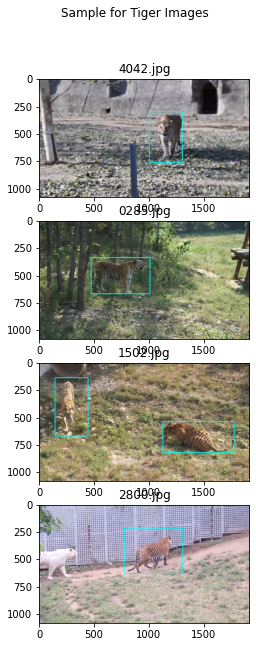

In [15]:
EDA().display_sample_images()

In [9]:
class QualityDegrader:
    
    def __init__(self):
        self.img = None
        self.mean = 0
        self.std = 0
        self.random_noise_img = None
        self.saltpepper_noise_img = None
        
    def __add_random_noise(self):
        
        self.mean = int(np.mean(self.img)*0.5)
        self.std = int(np.std(self.img)*1.25)
        noise = np.zeros(self.img.shape, np.uint8)
        cv2.randn(noise, self.mean, self.std)
        
        self.random_noise_img = cv2.add(self.img, noise)

    
    def __add_salt_pepper_noise(self):
        
        noise = np.zeros(self.img.shape, dtype=np.uint8)
        cv2.randu(noise, 0, 255)
        noise = cv2.threshold(noise, 190, 255, cv2.THRESH_BINARY)[1]
        
        self.saltpepper_noise_img = cv2.add(self.img, noise)
    
    def augment_dataset(self):
        self.train_image_paths = sorted(os.listdir(TRAIN_DIR))
        
        for img_path in self.train_image_paths:
            full_img_path = os.path.join(TRAIN_DIR, img_path)
            self.img = cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)
            self.__add_random_noise()
            self.__add_salt_pepper_noise()
            fn1, ext = img_path.split(".")
            img_rand_noise = fn1 + "_random"+"."+ext
            img_saltpepper_noise = fn1 + "_saltpepper"+"."+ext
            cv2.imwrite(os.path.join("../data/augmented_noisy_imgs/", img_rand_noise), self.random_noise_img)
            cv2.imwrite(os.path.join("../data/augmented_noisy_imgs/", img_saltpepper_noise), self.saltpepper_noise_img)

In [ ]:
qd = QualityDegrader()
qd.augment_dataset()

In [18]:
class ColorAugmentor:

    def __init__(self):
        self.train_img_paths = []
        self.img = None
        self.enhanced_img = None
        self.img_saturated = None
        self.contrast_factor = 1.5
        self.saturation_factor = 2

    def __add_contrast_to_img(self):

        enhancer = ImageEnhance.Contrast(self.img)
        self.enhanced_img = enhancer.enhance(self.contrast_factor)

    def __saturate_img(self):

        enhancer = ImageEnhance.Color(self.img)
        self.img_saturated = enhancer.enhance(self.saturation_factor)

    def augment(self):
        self.train_image_paths = sorted(os.listdir(TRAIN_DIR))
        
        for img_path in self.train_image_paths:
            full_img_path = os.path.join(TRAIN_DIR, img_path)
            self.img = Image.open(full_img_path)
            self.__add_contrast_to_img()
            self.__saturate_img()
            fn1, ext = img_path.split(".")
            img_contrasted = fn1 + "_contrast"+"."+ext
            img_saturate = fn1 + "_saturated"+"."+ext
            self.enhanced_img.save(os.path.join("../data/color_augmented_imgs/", img_contrasted))
            self.img_saturated.save(os.path.join("../data/color_augmented_imgs/", img_saturate))

In [19]:
ColorAugmentor().augment()